In [397]:
import pandas as pd
from os import listdir
from os.path import join, isfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
import pickle
import sys
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import statsmodels.formula.api as smf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as clr

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn import preprocessing

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from multiprocessing import Pool

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%time
path = "../data/financial-news-dataset-master/20061020_20131126_bloomberg_news/"
news_dataset = []
news_article = {}
date_headlines = {}

for date in tqdm(listdir(path)):
    if not isfile(join(path, date)): 
        date_headlines[date] = listdir(join(path, date))

  0%|          | 0/1945 [00:00<?, ?it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


100%|██████████| 1945/1945 [00:37<00:00, 51.97it/s]


In [4]:
%time
count = 0
fraction = 20
news_dataset = []

for date, headlines in tqdm(date_headlines.items()):
    for headline in headlines: 
        if (count % fraction) == 0:
            with open('../data/financial-news-dataset-master/20061020_20131126_bloomberg_news/' + date + '/' + headline) as f:
                #news_dataset.append({'Date': date, 'Headlines': headline, 'Content': f.readlines()}, ignore_index= True)
                news_dataset.append({'Date': date, 'Headlines': headline, 'Content': f.readlines()})
        count += 1

  0%|          | 1/1944 [00:00<05:54,  5.48it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


100%|██████████| 1944/1944 [01:14<00:00, 26.07it/s]


In [6]:
news_dataset = pd.DataFrame(news_dataset)
#date_headlines = pd.DataFrame(date_headlines)

In [7]:
news_dataset.head()

,Content,Date,Headlines
0,"[-- \n, Ivory Coast Keeps Cocoa Export Tax Bel...",2011-10-06,ivory-coast-keeps-cocoa-export-tax-below-22-do...
1,"[-- \n, Trichet Says ECB to Offer Longer Loans...",2011-10-06,richet-says-ecb-to-offer-longer-loans-will-res...
2,"[-- \n, Saft Chief Says Infrastructure So Far ...",2011-10-06,saft-chief-says-infrastructure-so-far-proving-...
3,"[-- \n, South Africa Daybook: Mining Output, Z...",2011-10-06,south-africa-daybook-business-confidence-elect...
4,"[-- \n, U.S. Stock Options With Biggest Change...",2011-10-06,u-s-stock-options-with-biggest-changes-in-impl...


In [ ]:
[news for sublist in list(news_dataset['Content']) for news in sublist]

General


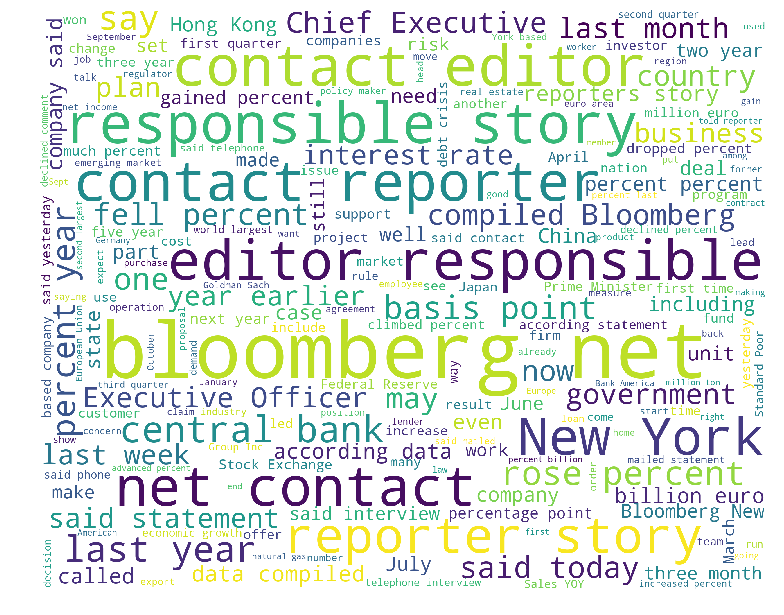

In [8]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("General")
wordcloud_draw([news for sublist in list(news_dataset['Content']) for news in sublist],'white')

In [11]:
news_dataset['Content'] = news_dataset['Content'].apply(lambda x: '. '.join(x))

In [16]:
news_dataset.head()

,Content,Date,Headlines
0,-- \n. Ivory Coast Keeps Cocoa Export Tax Belo...,2011-10-06,ivory-coast-keeps-cocoa-export-tax-below-22-do...
1,"-- \n. Trichet Says ECB to Offer Longer Loans,...",2011-10-06,richet-says-ecb-to-offer-longer-loans-will-res...
2,-- \n. Saft Chief Says Infrastructure So Far P...,2011-10-06,saft-chief-says-infrastructure-so-far-proving-...
3,"-- \n. South Africa Daybook: Mining Output, Zu...",2011-10-06,south-africa-daybook-business-confidence-elect...
4,-- \n. U.S. Stock Options With Biggest Changes...,2011-10-06,u-s-stock-options-with-biggest-changes-in-impl...


In [12]:
sentiment_list = pd.read_excel('../data/peripheral_data/inquirerbasic.xls')

In [13]:
sentiment_list.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
0,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
1,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
2,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
3,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
4,ABATEMENT,Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,NaN


## Convert to InquirerCount

In [14]:
sentiment_list = sentiment_list[['Entry']].join(sentiment_list.iloc[:,2:184].fillna(0).replace(r'.', 1, regex=True))

In [15]:
sentiment_list['Word'] = sentiment_list['Entry'].str.split('#', expand = True)[[0]]

In [8]:
sentiment_list.loc[sentiment_list['Word'] == 'GAIN'].any().to_dict()

{'ABS': False,
 'ANI': False,
 'Abs@': False,
 'Academ': False,
 'Active': True,
 'AffGain': False,
 'AffLoss': False,
 'AffOth': False,
 'AffPt': False,
 'AffTot': False,
 'Affil': False,
 'Anomie': False,
 'Aquatic': False,
 'ArenaLw': False,
 'Arousal': False,
 'Begin': False,
 'BldgPt': False,
 'BodyPt': False,
 'CARD': False,
 'COLL': False,
 'COLOR': False,
 'COM': False,
 'Causal': False,
 'ComForm': False,
 'ComnObj': False,
 'Compare': False,
 'Complet': True,
 'DAV': False,
 'DIM': False,
 'DIST': False,
 'Decreas': False,
 'Doctrin': False,
 'ECON': True,
 'EMOT': False,
 'EVAL': False,
 'Econ@': True,
 'EndsLw': True,
 'EnlEnds': False,
 'EnlGain': False,
 'EnlLoss': False,
 'EnlOth': False,
 'EnlPt': False,
 'EnlTot': False,
 'Entry': True,
 'Eval@': False,
 'Exch': False,
 'Exert': False,
 'Exprsv': False,
 'FREQ': False,
 'Fail': False,
 'Fall': False,
 'Feel': False,
 'Female': False,
 'Fetch': False,
 'Finish': False,
 'Food': False,
 'FormLw': False,
 'Goal': True,
 '

In [49]:
stop_words = set(stopwords.words('english'))

In [57]:
def inquirer_counter(item):
    
    
    date_sentiment = []
    cnt = Counter()
    temp_dict = {}
    
    #for item in tqdm(df):
    
    date = item[1]
    headlines = item[0]
    filtered_sentence = [w for w in headlines.split(' ') if not w in stop_words]

    for word in filtered_sentence:

        for key, value in sentiment_list.loc[sentiment_list['Word'] == word.upper()].any().to_dict().items():

            if value == True: 

                cnt[key] += 1

    #temp_dict = dict(cnt.items())
    temp_dict.update({'date': date, 'headline': headlines})
    temp_dict.update(dict(cnt.items()))
    cnt.clear()
    
    date_sentiment.append(temp_dict)
            
    return date_sentiment

In [58]:
p = Pool(4)
date_sentiment = p.map(inquirer_counter, news_dataset.values.tolist())

In [53]:
news_dataset.values.tolist()[1][0]

'-- \n. Trichet Says ECB to Offer Longer Loans, Will Resume Covered-Bond Purchases\n. \n. -- B y   G a b i   T h e s i n g\n. -- \n. 2011-10-06T12:50:46Z\n. \n. -- http://www.bloomberg.com/news/2011-10-06/trichet-says-ecb-to-offer-longer-loans-will-resume-covered-bond-purchases.html\n. European Central Bank President Jean-\n. Claude Trichet said the ECB will offer banks additional longer-\n. term liquidity and also restart its covered bond purchases.  The ECB will offer banks one 12-month loan, starting in\n. October, and a second 13-month loan in December. Both will be\n. operated as fixed rate, full allotment operations. It will also\n. start buying 40 billion euros of covered bonds in November.  To contact the reporter on this story:\n. Gabi Thesing in London at \n.  gthesing@bloomberg.net   To contact the editor responsible for this story:\n. John Fraher at \n.  jfraher@bloomberg.net  '

In [60]:
date_sentiment = [item[0] for item in date_sentiment]
date_sentiment = pd.DataFrame(date_sentiment).fillna(0)

In [594]:
del news_dataset

In [603]:
date_sentiment

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Word,Work,Yes,You
date,,,,,,,,,,,,,,,,,,,,,
2006-10-20,7.0,0.0,1.0,1.0,33.0,2.0,0.0,0.0,2.0,4.0,...,0.0,3.0,28.0,2.0,35.0,13.0,168.0,5.0,2.0,0.0
2006-10-30,17.0,0.0,1.0,1.0,36.0,7.0,0.0,0.0,0.0,7.0,...,0.0,2.0,7.0,3.0,11.0,1.0,171.0,9.0,0.0,0.0
2006-11-01,7.0,0.0,2.0,0.0,28.0,0.0,0.0,0.0,7.0,7.0,...,0.0,0.0,14.0,7.0,28.0,10.0,126.0,3.0,0.0,0.0
2006-11-13,21.0,0.0,6.0,2.0,33.0,2.0,0.0,0.0,2.0,4.0,...,0.0,4.0,13.0,5.0,19.0,2.0,139.0,9.0,1.0,0.0
2006-11-20,8.0,0.0,0.0,0.0,23.0,9.0,0.0,0.0,0.0,9.0,...,0.0,2.0,32.0,0.0,32.0,6.0,113.0,11.0,0.0,0.0
2006-12-12,4.0,0.0,2.0,0.0,14.0,0.0,0.0,0.0,1.0,1.0,...,0.0,4.0,7.0,2.0,11.0,6.0,51.0,4.0,0.0,0.0
2007-02-02,1.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,20.0,1.0,22.0,1.0,71.0,12.0,0.0,0.0
2007-03-08,10.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,6.0,6.0,...,0.0,1.0,16.0,9.0,30.0,7.0,109.0,5.0,0.0,0.0
2007-03-20,3.0,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,2.0,7.0,2.0,66.0,2.0,0.0,0.0


In [62]:
{w:v for w,v in date_sentiment.loc[date_sentiment['date'] == '2011-10-06'].to_dict(orient='records')[0].items() if v!=0}

{'ABS': 9.0,
 'Abs@': 2.0,
 'Active': 21.0,
 'AffGain': 1.0,
 'AffOth': 1.0,
 'AffTot': 2.0,
 'Affil': 6.0,
 'ArenaLw': 5.0,
 'Begin': 1.0,
 'CARD': 2.0,
 'COLL': 12.0,
 'COM': 14.0,
 'Causal': 3.0,
 'ComForm': 15.0,
 'ComnObj': 5.0,
 'Complet': 1.0,
 'DAV': 11.0,
 'Decreas': 1.0,
 'Doctrin': 4.0,
 'ECON': 26.0,
 'EVAL': 2.0,
 'Econ@': 16.0,
 'EndsLw': 6.0,
 'EnlGain': 8.0,
 'EnlOth': 5.0,
 'EnlPt': 3.0,
 'EnlTot': 12.0,
 'Entry': 117.0,
 'Exch': 2.0,
 'Fail': 1.0,
 'Finish': 1.0,
 'Food': 8.0,
 'FormLw': 12.0,
 'HU': 19.0,
 'Hostile': 6.0,
 'IAV': 29.0,
 'If': 2.0,
 'Increas': 2.0,
 'IndAdj': 1.0,
 'Know': 2.0,
 'Land': 4.0,
 'Legal': 4.0,
 'Means': 6.0,
 'NUMB': 4.0,
 'Name': 1.0,
 'NatObj': 1.0,
 'NegAff': 1.0,
 'Negativ': 9.0,
 'Ngtv': 9.0,
 'ORD': 2.0,
 'Object': 15.0,
 'Ought': 1.0,
 'Ovrst': 6.0,
 'PLACE': 12.0,
 'POLIT': 25.0,
 'POS': 2.0,
 'Passive': 10.0,
 'Persist': 2.0,
 'Pleasur': 1.0,
 'Polit@': 17.0,
 'Positiv': 10.0,
 'PowAren': 2.0,
 'PowAuPt': 3.0,
 'PowAuth': 2.0,
 '

In [815]:
date_sentiment['date'] = pd.to_datetime(date_sentiment['date'])
date_sentiment = date_sentiment.set_index('date')

In [813]:
date_sentiment.to_csv('../data/date_sentiment_bloomberg.csv', index = False)
#date_sentiment = pd.read_csv('../data/date_sentiment_bloomberg.csv')

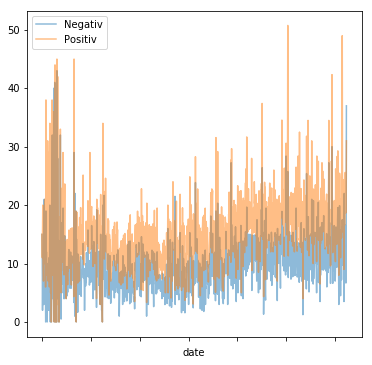

In [1006]:
date_sentiment[['Negativ', 'Positiv']].plot(alpha=0.5)

## Read and Process QQQ ETF that tracks the Nasdaq 100

In [905]:
nasdaq = pd.read_csv('../data/ETFs/qqq.us.txt')
#nasdaq = pd.read_csv('../data/stocks/tsla.us.txt')


In [906]:
nasdaq.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-03-10,45.722,45.750,44.967,45.665,11700414,0
1,1999-03-11,45.994,46.260,44.988,45.880,21670048,0
2,1999-03-12,45.721,45.749,44.406,44.770,19553768,0
3,1999-03-15,45.101,46.103,44.625,46.052,14245348,0
4,1999-03-16,46.253,46.643,45.749,46.447,10971066,0


In [907]:
def get_slope(df):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df, range(len(df)))
    
    return slope

## The Slope of the Closing Price of the QQ ETF, calculated over 5 trading days

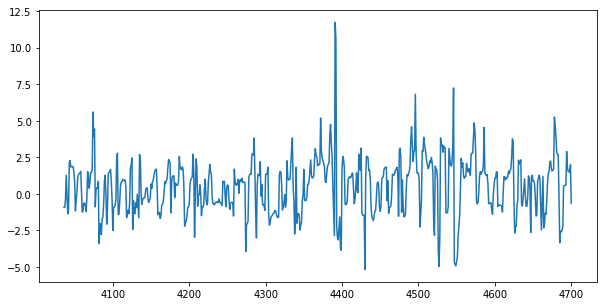

In [908]:
nasdaq['Close'].rolling(window=5,center=False,min_periods=5).apply(func = get_slope)[-665:].plot()

In [909]:
nasdaq['CloseSlope'] = nasdaq['Close'].rolling(window=3,center=False,min_periods=3).apply(func = get_slope)
nasdaq['OpenSlope'] = nasdaq['Open'].rolling(window=3,center=False,min_periods=3).apply(func = get_slope)
nasdaq['HighSlope'] = nasdaq['High'].rolling(window=3,center=False,min_periods=3).apply(func = get_slope)
nasdaq['LowSlope'] = nasdaq['Low'].rolling(window=3,center=False,min_periods=3).apply(func = get_slope)

## The Difference in the slope between t and t-1 days

## Comparing the QQQ ETF Values, Slope and Slope Differential Values

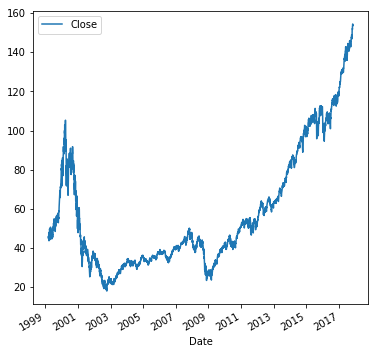

In [1008]:
nasdaq[['Close']].plot()

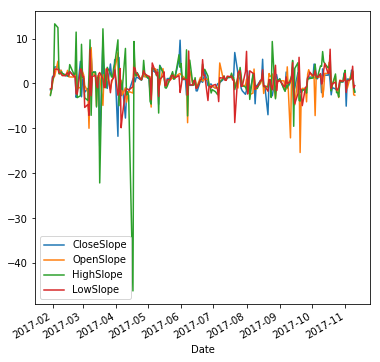

In [1007]:
nasdaq.tail(200)[['CloseSlope', 'OpenSlope', 'HighSlope', 'LowSlope']].plot()

In [911]:
nasdaq['bull'] = nasdaq['CloseSlope'] > 0

## Map InquirerCount to QQQ ETF; i.e. Each date is broken down to Sentiment Counts

In [912]:
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq = nasdaq.set_index('Date')

In [913]:
date_sentiment = date_sentiment.groupby('date').mean()

In [1010]:
date_sentiment.tail()

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,Affil,Anomie,Aquatic,ArenaLw,Arousal,Begin,BldgPt,BodyPt,CARD,COLL,COLOR,COM,Causal,ComForm,ComnObj,Compare,Complet,DAV,DIM,DIST,Decreas,Doctrin,ECON,EMOT,EVAL,Econ@,EndsLw,EnlEnds,EnlGain,EnlLoss,EnlOth,EnlPt,EnlTot,Entry,Eval@,Exch,Exert,Exprsv,FREQ,Fail,Fall,Feel,Female,Fetch,Finish,Food,FormLw,Goal,HU,Hostile,IAV,IPadj,If,Increas,IndAdj,Intrj,Kin@,Know,Land,Legal,MALE,Means,MeansLw,Milit,NUMB,Name,NatObj,Nation,NatrPro,Need,NegAff,Negate,Negativ,Ngtv,No,Nonadlt,NotLw,ORD,Object,Ought,Our,Ovrst,PLACE,POLIT,POS,Pain,Passive,Perceiv,Persist,Pleasur,Polit@,PosAff,Positiv,PowAren,PowAuPt,PowAuth,PowCon,PowCoop,PowDoct,PowEnds,PowGain,PowLoss,PowOth,PowPt,PowTot,Power,Pstv,PtLw,Quality,Quan,Race,RcEnds,RcEthic,RcGain,RcLoss,RcRelig,RcTot,Region,Rel,Relig,Rise,Ritual,Role,Route,RspGain,RspLoss,RspOth,RspTot,SV,Say,Self,SklAsth,SklOth,SklPt,SklTot,Sky,SocRel,Social,Solve,Space,Stay,Strong,Submit,SureLw,TIME,Think,Time@,TimeSpc,Tool,TranLw,Travel,TrnGain,TrnLoss,Try,Undrst,Vary,Vehicle,Vice,Virtue,Weak,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Word,Work,Yes,You
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-22,14.352941,0.117647,5.588235,5.058824,37.235294,1.235294,0.411765,1.235294,0.705882,3.352941,14.117647,0.0,0.235294,2.647059,2.470588,2.764706,1.058824,1.588235,6.941176,11.647059,0.352941,17.294118,4.588235,21.294118,3.764706,1.529412,2.823529,25.588235,2.058824,0.235294,1.117647,7.352941,33.294118,4.411765,5.705882,22.705882,11.470588,0.294118,13.235294,0.058824,16.705882,3.352941,27.411765,180.235294,0.588235,3.058824,1.882353,3.058824,2.823529,2.117647,1.000000,0.0,0.058824,2.352941,2.000000,0.294118,17.588235,2.352941,20.705882,7.823529,40.176471,0.117647,5.470588,3.235294,1.529412,1.294118,0.235294,8.411765,1.941176,4.411765,0.529412,12.117647,2.882353,1.058824,9.823529,5.705882,1.117647,1.352941,4.117647,2.529412,2.411765,2.235294,16.529412,14.941176,0.058824,0.235294,0.411765,2.882353,11.176471,0.235294,0.411765,18.352941,9.882353,22.647059,4.411765,2.823529,14.411765,2.470588,2.588235,0.705882,7.352941,2.411765,24.176471,2.705882,5.823529,2.176471,1.294118,2.235294,0.058824,1.058824,2.411765,1.529412,8.588235,2.294118,26.470588,19.823529,21.764706,1.294118,4.588235,24.176471,0.000000,0.176471,3.117647,1.058824,0.0,0.117647,4.352941,1.705882,5.529412,0.470588,1.235294,3.294118,10.117647,0.705882,0.764706,0.411765,2.647059,3.823529,4.529412,4.588235,0.647059,0.529412,3.705882,0.470588,4.235294,0.117647,13.647059,5.176471,8.176471,9.941176,1.176471,41.235294,3.705882,5.823529,8.647059,0.470588,17.588235,21.705882,4.882353,7.352941,5.941176,6.235294,2.764706,2.705882,5.705882,2.117647,0.294118,6.411765,12.882353,9.352941,2.058824,0.529412,3.352941,0.705882,0.176471,6.470588,18.411765,3.411765,22.588235,2.117647,180.235294,7.705882,0.529412,0.058824
2013-11-23,14.666667,0.000000,3.666667,2.333333,39.000000,3.333333,1.000000,1.333333,0.666667,5.666667,16.000000,0.0,0.666667,3.000000,4.000000,3.333333,0.333333,0.666667,4.333333,8.666667,0.333333,21.666667,4.333333,24.333333,7.333333,2.666667,4.333333,24.000000,2.000000,0.333333,1.333333,7.666667,31.333333,4.000000,3.333333,21.000000,13.000000,0.000000,10.000000,0.000000,20.333333,2.000000,26.333333,188.333333,0.333333,2.666667,2.333333,1.333333,4.666667,1.000000,2.000000,0.0,0.000000,1.333333,1.666667,0.333333,17.666667,2.333333,15.333333,6.666667,46.000000,0.333333,7.000000,2.333333,0.666667,1.666667,0.000000,6.666667,2.666667,1.333333,0.000000,10.666667,4.333333,1.333333,8.000000,8.666667,1.333333,7.333333,3.000000,2.333333,1.666667,2.000000,12.333333,9.666667,0.000000,0.000000,1.000000,3.666667,13.000000,0.333333,0.333333,16.666667,10.000000,28.000000,7.000000,0.333333,12.000000,4.000000,2.666667,1.000000,8.333333,3.000000,21.33333

In [915]:
nasdaq.head()

,Open,High,Low,Close,Volume,OpenInt,CloseSlope,OpenSlope,HighSlope,LowSlope,bull
Date,,,,,,,,,,,
1999-03-10,45.722,45.750,44.967,45.665,11700414,0,NaN,NaN,NaN,NaN,False
1999-03-11,45.994,46.260,44.988,45.880,21670048,0,NaN,NaN,NaN,NaN,False
1999-03-12,45.721,45.749,44.406,44.770,19553768,0,-1.291269,-0.020200,-0.005756,-2.573843,False
1999-03-15,45.101,46.103,44.625,46.052,14245348,0,0.177612,-2.132320,-1.145746,-2.100476,True
1999-03-16,46.253,46.643,45.749,46.447,10971066,0,1.090879,0.800189,2.205316,1.293425,True


In [1013]:
merger = date_sentiment.merge(nasdaq, how='left', left_index = True, right_index = True)
merger

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,Affil,Anomie,Aquatic,ArenaLw,Arousal,Begin,BldgPt,BodyPt,CARD,COLL,COLOR,COM,Causal,ComForm,ComnObj,Compare,Complet,DAV,DIM,DIST,Decreas,Doctrin,ECON,EMOT,EVAL,Econ@,EndsLw,EnlEnds,EnlGain,EnlLoss,EnlOth,EnlPt,EnlTot,Entry,Eval@,Exch,Exert,Exprsv,FREQ,Fail,Fall,Feel,Female,Fetch,Finish,Food,FormLw,Goal,HU,Hostile,IAV,IPadj,If,Increas,IndAdj,Intrj,Kin@,Know,Land,Legal,MALE,Means,MeansLw,Milit,NUMB,Name,NatObj,Nation,NatrPro,Need,NegAff,Negate,Negativ,Ngtv,No,Nonadlt,NotLw,ORD,Object,Ought,Our,Ovrst,PLACE,POLIT,POS,Pain,Passive,Perceiv,Persist,Pleasur,Polit@,PosAff,Positiv,PowAren,PowAuPt,PowAuth,PowCon,PowCoop,PowDoct,PowEnds,PowGain,PowLoss,PowOth,PowPt,PowTot,Power,Pstv,PtLw,Quality,Quan,Race,RcEnds,RcEthic,RcGain,RcLoss,RcRelig,RcTot,Region,Rel,Relig,Rise,Ritual,Role,Route,RspGain,RspLoss,RspOth,RspTot,SV,Say,Self,SklAsth,SklOth,SklPt,SklTot,Sky,SocRel,Social,Solve,Space,Stay,Strong,Submit,SureLw,TIME,Think,Time@,TimeSpc,Tool,TranLw,Travel,TrnGain,TrnLoss,Try,Undrst,Vary,Vehicle,Vice,Virtue,Weak,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Word,Work,Yes,You,Open,High,Low,Close,Volume,OpenInt,CloseSlope,OpenSlope,HighSlope,LowSlope,bull
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-10-20,7.000000,0.000000,1.000000,1.000000,33.000000,2.000000,0.000000,0.000000,2.000000,4.000000,15.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,11.000000,3.000000,0.000000,24.000000,2.000000,26.000000,6.000000,2.000000,6.000000,28.000000,2.000000,0.000000,2.000000,2.000000,48.000000,1.000000,3.000000,47.000000,11.000000,0.000000,10.000000,0.000000,16.000000,2.000000,23.000000,168.000000,0.000000,9.000000,5.000000,0.000000,6.000000,1.000000,3.000000,0.000000,0.000000,2.000000,4.000000,0.000000,22.000000,3.000000,13.000000,11.000000,48.000000,0.000000,1.000000,3.000000,0.000000,2.000000,0.000000,5.000000,2.000000,0.000000,0.000000,15.000000,4.000000,3.000000,12.000000,5.000000,18.000000,4.000000,3.000000,0.000000,2.000000,2.000000,15.000000,13.000000,0.000000,0.000000,0.000000,1.000000,34.000000,0.000000,0.000000,21.000000,8.000000,18.000000,1.000000,1.000000,11.000000,4.000000,2.000000,0.000000,2.000000,0.000000,15.000000,0.000000,5.000000,1.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.000000,4.000000,0.000000,16.000000,18.000000,14.000000,1.000000,5.000000,30.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.000000,2.000000,0.000000,1.000000,3.000000,10.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,5.000000,1.000000,0.000000,4.000000,1.000000,5.000000,0.000000,11.000000,2.000000,14.000000,3.000000,0.000000,46.000000,0.000000,4.000000,6.000000,0.000000,10.000000,17.000000,10.000000,3.000000,3.000000,7.000000,6.000000,1.000000,4.000000,1.000000,0.000000,6.000000,9.000000,6.000000,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000,28.000000,2.000000,35.000000,13.000000,168.000000,5.000000,2.000000,0.000000,38.172,38.210,37.809,38.135,116136535.0,0.0,10.810706,-1.341674,-8.259056,-1.759875,True
2006-10-30,17.000000,0.000000,1.000000,1.000000,36.000000,7.000000,0.000000,0.000000,0.000000,7.000000,16.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,23.000000,1.000000,20.000000,8.000000,1.000000,2.000000,25.000000,1.000000,0.000000,1.000000,1.000000,31.000000,2.000000,8.000000,11.000000,7.000000,0.000000,16.000000,0.000000,20.000000,11.000000,43.000000,171.000000,0.000000,2.000000,0.000000,2.000000,7.000000,2.000000,11.000000,0.000000,0.000000,0.000000,7.000000,0.000000,17.000000,0.000000,18.000000,3.000000,28.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,8.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000,9.000000,18.000000,3.000000,0.000000,8.000000,1.000000,1.

In [1014]:
merger

,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,Affil,Anomie,Aquatic,ArenaLw,Arousal,Begin,BldgPt,BodyPt,CARD,COLL,COLOR,COM,Causal,ComForm,ComnObj,Compare,Complet,DAV,DIM,DIST,Decreas,Doctrin,ECON,EMOT,EVAL,Econ@,EndsLw,EnlEnds,EnlGain,EnlLoss,EnlOth,EnlPt,EnlTot,Entry,Eval@,Exch,Exert,Exprsv,FREQ,Fail,Fall,Feel,Female,Fetch,Finish,Food,FormLw,Goal,HU,Hostile,IAV,IPadj,If,Increas,IndAdj,Intrj,Kin@,Know,Land,Legal,MALE,Means,MeansLw,Milit,NUMB,Name,NatObj,Nation,NatrPro,Need,NegAff,Negate,Negativ,Ngtv,No,Nonadlt,NotLw,ORD,Object,Ought,Our,Ovrst,PLACE,POLIT,POS,Pain,Passive,Perceiv,Persist,Pleasur,Polit@,PosAff,Positiv,PowAren,PowAuPt,PowAuth,PowCon,PowCoop,PowDoct,PowEnds,PowGain,PowLoss,PowOth,PowPt,PowTot,Power,Pstv,PtLw,Quality,Quan,Race,RcEnds,RcEthic,RcGain,RcLoss,RcRelig,RcTot,Region,Rel,Relig,Rise,Ritual,Role,Route,RspGain,RspLoss,RspOth,RspTot,SV,Say,Self,SklAsth,SklOth,SklPt,SklTot,Sky,SocRel,Social,Solve,Space,Stay,Strong,Submit,SureLw,TIME,Think,Time@,TimeSpc,Tool,TranLw,Travel,TrnGain,TrnLoss,Try,Undrst,Vary,Vehicle,Vice,Virtue,Weak,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Word,Work,Yes,You,Open,High,Low,Close,Volume,OpenInt,CloseSlope,OpenSlope,HighSlope,LowSlope,bull
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-10-20,7.000000,0.000000,1.000000,1.000000,33.000000,2.000000,0.000000,0.000000,2.000000,4.000000,15.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,11.000000,3.000000,0.000000,24.000000,2.000000,26.000000,6.000000,2.000000,6.000000,28.000000,2.000000,0.000000,2.000000,2.000000,48.000000,1.000000,3.000000,47.000000,11.000000,0.000000,10.000000,0.000000,16.000000,2.000000,23.000000,168.000000,0.000000,9.000000,5.000000,0.000000,6.000000,1.000000,3.000000,0.000000,0.000000,2.000000,4.000000,0.000000,22.000000,3.000000,13.000000,11.000000,48.000000,0.000000,1.000000,3.000000,0.000000,2.000000,0.000000,5.000000,2.000000,0.000000,0.000000,15.000000,4.000000,3.000000,12.000000,5.000000,18.000000,4.000000,3.000000,0.000000,2.000000,2.000000,15.000000,13.000000,0.000000,0.000000,0.000000,1.000000,34.000000,0.000000,0.000000,21.000000,8.000000,18.000000,1.000000,1.000000,11.000000,4.000000,2.000000,0.000000,2.000000,0.000000,15.000000,0.000000,5.000000,1.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.000000,4.000000,0.000000,16.000000,18.000000,14.000000,1.000000,5.000000,30.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.000000,2.000000,0.000000,1.000000,3.000000,10.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,5.000000,1.000000,0.000000,4.000000,1.000000,5.000000,0.000000,11.000000,2.000000,14.000000,3.000000,0.000000,46.000000,0.000000,4.000000,6.000000,0.000000,10.000000,17.000000,10.000000,3.000000,3.000000,7.000000,6.000000,1.000000,4.000000,1.000000,0.000000,6.000000,9.000000,6.000000,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000,28.000000,2.000000,35.000000,13.000000,168.000000,5.000000,2.000000,0.000000,38.172,38.210,37.809,38.135,116136535.0,0.0,10.810706,-1.341674,-8.259056,-1.759875,True
2006-10-30,17.000000,0.000000,1.000000,1.000000,36.000000,7.000000,0.000000,0.000000,0.000000,7.000000,16.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,23.000000,1.000000,20.000000,8.000000,1.000000,2.000000,25.000000,1.000000,0.000000,1.000000,1.000000,31.000000,2.000000,8.000000,11.000000,7.000000,0.000000,16.000000,0.000000,20.000000,11.000000,43.000000,171.000000,0.000000,2.000000,0.000000,2.000000,7.000000,2.000000,11.000000,0.000000,0.000000,0.000000,7.000000,0.000000,17.000000,0.000000,18.000000,3.000000,28.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,8.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000,9.000000,18.000000,3.000000,0.000000,8.000000,1.000000,1.

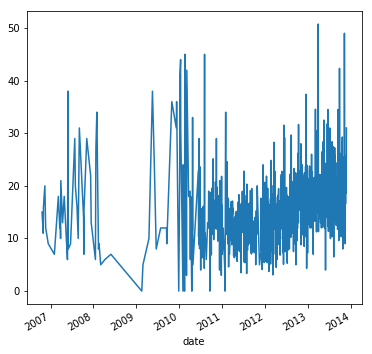

In [1015]:
merger['Positiv'].plot()

## Comaparing the raw value of the QQQ ETF and mean value of sentiments for that day

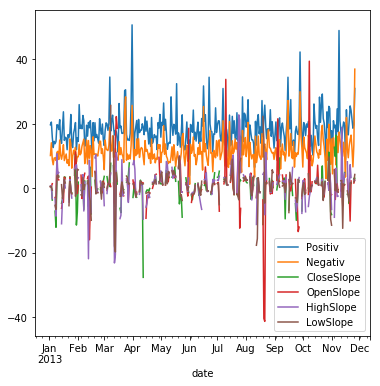

In [1016]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ', 'CloseSlope', 'OpenSlope', 'HighSlope', 'LowSlope']].plot()

In [921]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ']].corr()

,Positiv,Negativ
Positiv,1.000000,0.798516
Negativ,0.798516,1.000000


In [922]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ','CloseSlope']]

,Positiv,Negativ,CloseSlope
Date,,,
2013-01-02,19.750000,10.187500,0.608560
2013-01-03,20.578947,14.157895,0.740592
2013-01-04,15.944444,8.944444,-3.645676
2013-01-07,13.857143,9.476190,-7.052891
2013-01-08,14.560000,8.680000,-12.082584
2013-01-09,19.760000,11.200000,4.127344
2013-01-10,19.615385,11.500000,3.204514
2013-01-11,18.250000,8.958333,3.804428
2013-01-14,13.961538,9.038462,-4.640698


## To Do

- Remove Weekends
- Tease out correlations
- Apply Naive Bayes
- Apply LSTM

## Scatter Plot of Positve and Negative Mean Sentiments

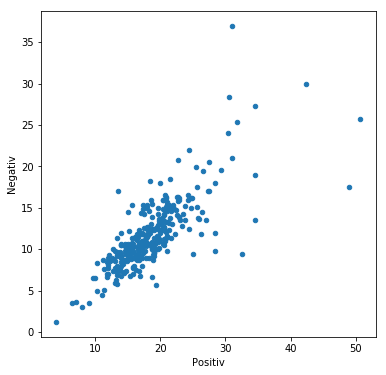

In [1017]:
merger.iloc[merger.index>'2013'][['Positiv', 'Negativ']].plot.scatter('Positiv', 'Negativ')

## Notes

- Negative correlation appears to be stronger at extremes, which appears to check in intuitively
- Filter by strong values maybe?

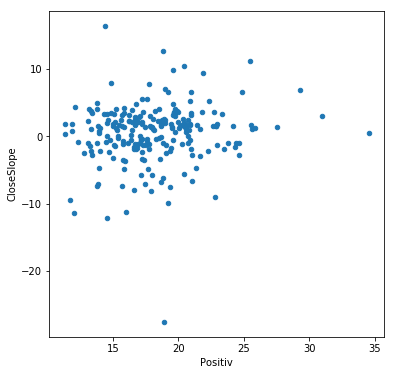

In [1018]:
merger.iloc[merger.index>'2013'][['Positiv', 'CloseSlope']].plot.scatter('Positiv', 'CloseSlope')

In [116]:
merger.iloc[merger.index>'2013'][['Positiv', 'High Slope']].corr()

,Positiv,High Slope
Positiv,1.000000,-0.089684
High Slope,-0.089684,1.000000


## Correlations of General Inquirer Sentiments with respect to Slope of the 5 day Close Price and it's one day differential.

In [923]:
slope_correlations = merger.iloc[merger.index>'2013'].corr()[['CloseSlope', 'HighSlope', 'LowSlope', 'OpenSlope']]

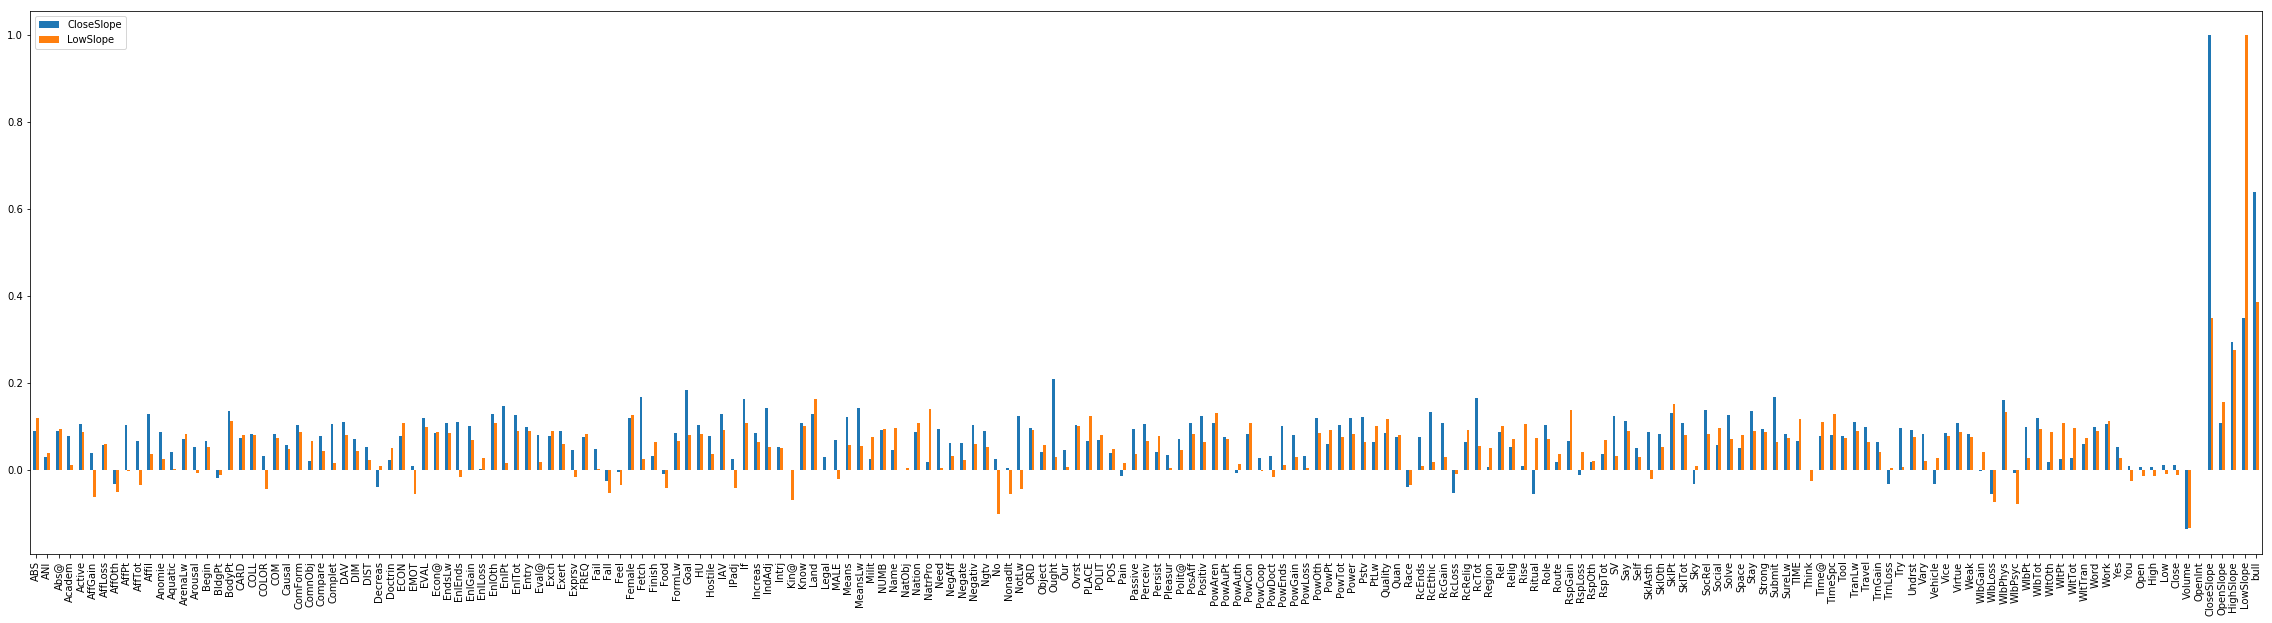

In [924]:
rcParams['figure.figsize'] = 40, 10
merger.iloc[merger.index>'2013'].corr()[['CloseSlope', 'LowSlope']].plot.bar()

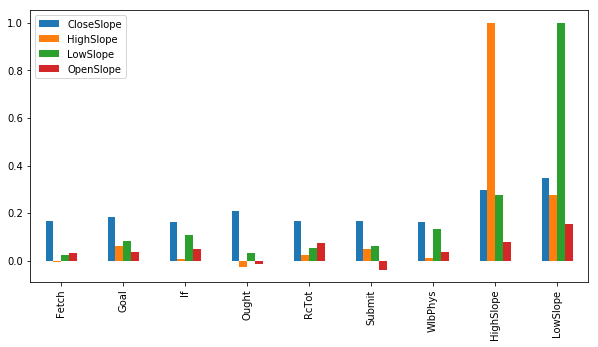

In [1019]:
rcParams['figure.figsize'] = 10, 5
plot = slope_correlations.loc[((slope_correlations['CloseSlope'] > 0.15) | (slope_correlations['CloseSlope'] < -0.15))\
                            & (slope_correlations['CloseSlope'] < 0.4)].plot.bar()

In [162]:
slope_correlations.loc[((slope_correlations['Close Slope'] > 0.1) | (slope_correlations['Close Slope'] < -0.1))\
                            & (slope_correlations['Close Slope'] < 0.4)].index

Index(['Aquatic', 'BodyPt', 'Decreas', 'Exert', 'Goal', 'NatObj', 'Nation',
       'PowGain', 'RcRelig', 'Route', 'RspLoss', 'SklOth', 'Stay', 'Submit',
       'You', 'Volume'],
      dtype='object')

## Notes

Weak Negative Correlation Between:

Decreas* = Other process or change words. Words like depreciate, dwindle etc
NotLw   = words "that show the denial of one sort or another."
AffTot*  = Affection is the valuing of love and friendship
Place   = References to places, locations and routes between them. (?)
TranLw  = Words of transaction or exchange in a broad sense, but not necessarily of gain or loss.
DIM*    = Words relating to space and dimension; like big, breif, broad, considerable, endless, enormous
POS     = Words for position; Words like Adjascent, centre, follow, high
TrnGain = General words of accomplishment; words like additon, acquire, affirm, bestow, broke, caught, clearence (?)
Social* = Words for created locations that typically provide for social interaction and occupy limited space
Try*     = Indicating activities taken to reach a goal
PowCon   = Power conflict

Weak Positive Correlation Between:

RcEthic* = words of values concerning the social order.
WltTran  = Wealth transaction, 53 words for pursuit of wealth, such as buying and selling.
Solve    = words (mostly verbs) referring to the mental processes associated with problem solving.
RcGain*  = Rectitude gain, 30 words such as worship and forgiveness.
RcTot*   = Rectitude is concerned with moral value
RspLoss* = Words for the losing of respect, such as shame (?)
Exch     = Words concerned with buying, selling and trading
if*      = Words "denoting feelings of uncertainty, doubt and vagueness."
Travel   = Words for all physical movement and travel from one place to another in a horizontal plane)
Anomie   = Words that usually show "a negation of value preference", nihilism, disappointment and futility.

Also note that the volume is negatively correlated with slope. 

## Multinomial NB

In [1020]:
merger['bull'] = merger['CloseSlope'] > 0
merger['bull_tomorrow'] = merger['bull'].shift(-7)

In [1021]:
train, test = train_test_split(merger.dropna(),test_size = 0.25)

In [1022]:
train.iloc[:,-1]

date
2010-12-02     True
2013-10-15     True
2013-05-15    False
2013-10-07     True
2012-06-21    False
2012-10-16    False
2011-05-13    False
2011-04-25    False
2010-10-13    False
2010-11-26     True
2010-07-16     True
2007-10-12     True
2012-08-03     True
2011-02-16    False
2011-03-08    False
2011-11-30    False
2013-01-09    False
2012-07-27     True
2011-08-09     True
2013-03-25    False
2013-10-17    False
2006-11-20    False
2007-03-21     True
2011-06-13     True
2008-04-08     True
2013-01-02     True
2012-10-01    False
2013-10-30     True
2012-11-21     True
2012-12-06    False
              ...  
2010-11-11     True
2011-06-16     True
2007-10-11     True
2013-05-23     True
2013-05-10     True
2012-03-08     True
2012-09-07     True
2012-07-25    False
2013-02-26     True
2011-10-06     True
2011-08-19     True
2011-02-07     True
2011-09-14    False
2011-11-16    False
2011-07-08     True
2011-06-09    False
2013-11-15     True
2012-05-04    False
2013-05-03     

In [1023]:
from sklearn.naive_bayes import MultinomialNB

train_X = train.iloc[:,0:-12]
train_Y = train.iloc[:,-1].astype('int')

clf = MultinomialNB(alpha = 1)
clf.fit(train_X, train_Y)

bnb_yhat = clf.predict(train_X)

In [1024]:
test_X = test.iloc[:,0:-12]
test_Y = test.iloc[:,-1].astype('int')

print("Accuracy: %0.3f" % metrics.accuracy_score(np.array(train_Y), bnb_yhat))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(train_Y), bnb_yhat))
print("Completeness: %0.3f" % metrics.completeness_score(np.array(train_Y), bnb_yhat))
print("V-measure: %0.3f" % metrics.v_measure_score(np.array(train_Y), bnb_yhat))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(np.array(train_Y),bnb_yhat))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_X, np.array(train_Y)))

Accuracy: 0.587
Homogeneity: 0.016
Completeness: 0.017
V-measure: 0.016
Adjusted Rand-Index: 0.028
Silhouette Coefficient: 0.001


## Bernoulli Naive Bayes

In [1030]:
from sklearn.naive_bayes import BernoulliNB

merger['bull'] = merger['CloseSlope'] > 0
merger['bull_tomorrow'] = merger['bull'].shift(-4)

train, test = train_test_split(merger.dropna(),test_size = 0.15)

train_X = train.iloc[:,0:-12]
train_Y = train.iloc[:,-1].astype('int')

clf = BernoulliNB(alpha = 1, binarize = 1)
clf.fit(train_X, train_Y)

bnb_yhat = clf.predict(train_X)

In [1031]:
import sklearn.metrics as metrics

test_X = test.iloc[:,0:-12]
test_Y = test.iloc[:,-1].astype('int')

clf.score(test_X, test_Y)


print("Accuracy: %0.3f" % metrics.accuracy_score(np.array(train_Y), bnb_yhat))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(train_Y), bnb_yhat))
print("Completeness: %0.3f" % metrics.completeness_score(np.array(train_Y), bnb_yhat))
print("V-measure: %0.3f" % metrics.v_measure_score(np.array(train_Y), bnb_yhat))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(np.array(train_Y),bnb_yhat))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_X, np.array(train_Y)))

Accuracy: 0.668
Homogeneity: 0.022
Completeness: 0.032
V-measure: 0.026
Adjusted Rand-Index: 0.069
Silhouette Coefficient: 0.056


In [1032]:
## For use later
train, test = train_test_split(merger.dropna(),test_size = 0)
train_X = train.iloc[:,0:-12]
bnb_yhat = clf.predict(train_X)

## Bernoulli Naive Bayes over multiple shifts

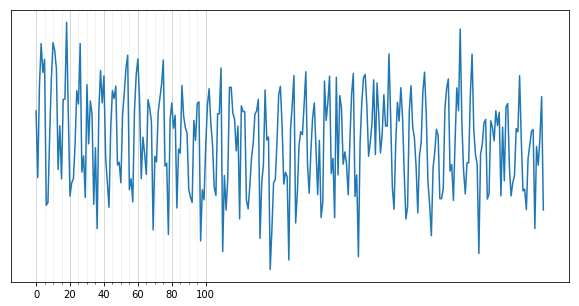

In [1028]:
from sklearn.naive_bayes import BernoulliNB

future_accuracy = []
range_val = 300 

for future in range(range_val):

    merger['bull_tomorrow'] = merger['bull'].shift(-future)
    train, test = train_test_split(merger.dropna(),test_size = 0.35)

    train_X = train.iloc[:,0:-13]
    train_Y = train.iloc[:,-1].astype('int')

    #print (train_X)
    clf = BernoulliNB(alpha = 1, binarize = 1)
    clf.fit(train_X, train_Y)

    test_X = test.iloc[:,0:-13]
    test_Y = test.iloc[:,-1].astype('int')

    future_accuracy.append(clf.score(test_X, test_Y))


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

#plt.show()

#plt.grid(which='both')
plt.plot(range(range_val), future_accuracy)

A decreasing accuracy as we attempt to predict further into the future is *not* observed. The chart appears to be fairly random. Although, there does appear to be a pattern here. Let's investigate

In [1029]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

autocorr(future_accuracy, 7)

array([[1.        , 0.55078632],
       [0.55078632, 1.        ]])

There is a strong 7-interval periodicity in the accuracy of the model. Predicting the Bull/Bear of every t + 7th day, given the sentiments of t, is surprisingly accurate. Maybe autocorrelation in the slope differential needs to be investigated?

## Investigating periodicity in slopes

In [302]:
corrs = []
for t in range(10):
    corrs.append(autocorr(np.array(merger['Close Slope Differential'].dropna()), t)[0][1])

In [207]:
corrs = []
for t in range(10):
    corrs.append(autocorr(np.array(merger['Close Slope'].dropna()), t)[0][1])


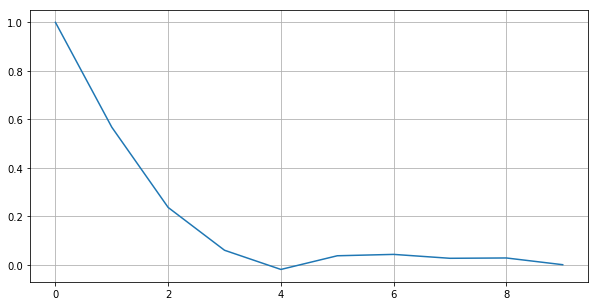

In [208]:
plt.grid(which='both')
plt.plot(range(10), corrs)

## Multivariate Regression

## Rename Column names for Statsmodel

In [1033]:
print(smf.ols(formula="CloseSlope ~ "
                      + "Aquatic + BodyPt + Decreas + Exert + Goal + NatObj + Nation +" 
                      + "PowGain + RcRelig + Route + RspLoss + SklOth + Stay + Submit +" 
                      + "You", data=merger).fit().summary())



                            OLS Regression Results                            
Dep. Variable:             CloseSlope   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.291
Date:                Sat, 21 Apr 2018   Prob (F-statistic):              0.201
Time:                        18:49:08   Log-Likelihood:                -2593.0
No. Observations:                 878   AIC:                             5218.
Df Residuals:                     862   BIC:                             5294.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2311      0.542     -0.426      0.6

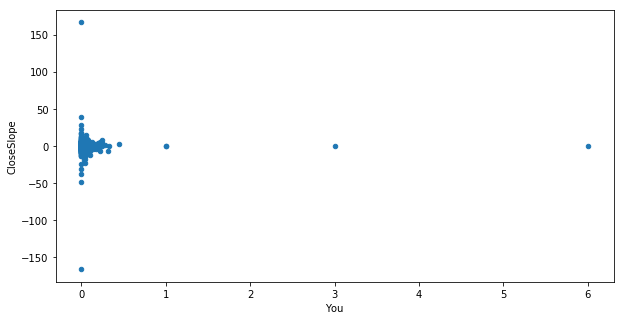

In [837]:
merger.plot.scatter(x = 'You', y = 'CloseSlope')

## Scatter Plots of the highest and lowest Regression Coefficients

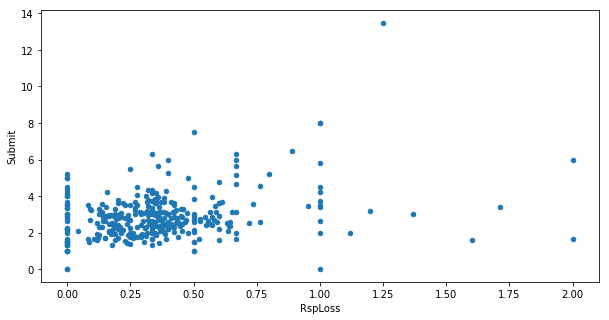

In [838]:
merger.iloc[merger.index>'2013'].plot.scatter('RspLoss', 'Submit')

## K-Means

In [1203]:
from sklearn.cluster import KMeans

merger['bull'] = merger['CloseSlope'] > 0
merger['bull_tomorrow'] = merger['bull'].shift(-3)

train, test = train_test_split(merger.dropna(),test_size = 0)

train_X = train.iloc[:,0:-12]
train_Y = train.iloc[:,-1].astype('int')

train_X = preprocessing.scale(train_X, axis=0, with_mean=True, with_std=True, copy=True)

kmeans = KMeans(n_clusters=2, random_state=4, n_init=2, max_iter=1000).fit(train_X)


In [1204]:
import sklearn.metrics as metrics

print("Accuracy: %0.3f" % metrics.accuracy_score(np.array(train_Y), 1 - kmeans.labels_))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(train_Y), 1 - kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(np.array(train_Y), 1 - kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(np.array(train_Y), 1 - kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(np.array(train_Y), 1 - kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_X, np.array(train_Y)))


Accuracy: 0.483
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.001
Silhouette Coefficient: 0.039


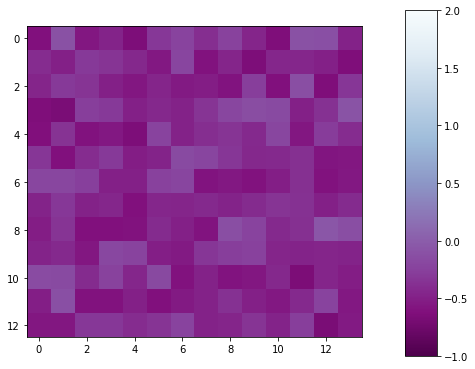

In [1062]:
rcParams['figure.figsize'] = 6, 6
plt.imshow(kmeans.cluster_centers_[1][0:182].reshape(13, 14), cmap=plt.cm.BuPu_r, norm=clr.Normalize(vmin=-1, vmax=2, clip=False))
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

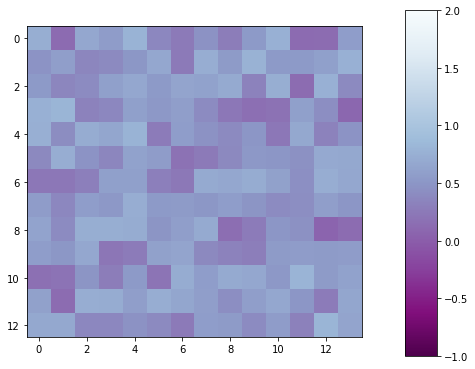

In [1063]:
rcParams['figure.figsize'] = 6, 6
plt.imshow(kmeans.cluster_centers_[0][0:182].reshape(13, 14), cmap=plt.cm.BuPu_r, norm=clr.Normalize(vmin=-1, vmax=2, clip=False))
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

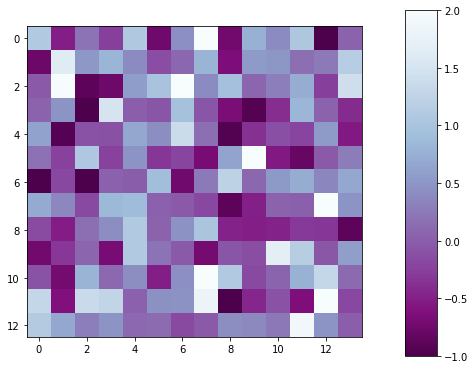

In [1064]:
rcParams['figure.figsize'] = 6, 6
plt.imshow(train_X1[-3][0:182].reshape(13, 14), cmap=plt.cm.BuPu_r, norm=clr.Normalize(vmin=-1, vmax=2, clip=False))
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

## DBScan

In [1192]:
from sklearn.cluster import DBSCAN

merger['bull'] = merger['CloseSlope'] > 0
merger['bull_tomorrow'] = merger['bull'].shift(-3)

train, test = train_test_split(merger.dropna(),test_size = 0)

train_X = train.iloc[:,0:-12]
train_Y = train.iloc[:,-1].astype('int')

train_X = preprocessing.scale(train_X, axis=0, with_mean=True, with_std=True, copy=True)

dbscan = DBSCAN(eps=0.5, min_samples=100, metric='cosine', metric_params=None, leaf_size=30, p=None, n_jobs=1).fit(train_X)

In [1193]:
dbscan.core_sample_indices_

array([  1,   2,   6,  10,  11,  13,  15,  16,  19,  21,  22,  23,  24,
        25,  26,  29,  30,  37,  40,  44,  47,  50,  51,  58,  59,  63,
        68,  69,  71,  74,  76,  78,  86,  88,  89,  90,  92,  96,  97,
        98,  99, 101, 104, 105, 107, 108, 110, 112, 115, 122, 124, 128,
       130, 133, 134, 138, 140, 141, 142, 143, 144, 148, 149, 150, 152,
       155, 157, 159, 160, 162, 163, 165, 169, 171, 174, 178, 179, 181,
       182, 184, 188, 189, 190, 191, 192, 193, 194, 195, 199, 200, 202,
       205, 207, 211, 212, 213, 217, 219, 223, 224, 226, 227, 228, 229,
       230, 232, 235, 237, 238, 239, 245, 247, 251, 253, 259, 260, 262,
       264, 267, 269, 270, 271, 272, 281, 283, 284, 288, 290, 293, 296,
       298, 301, 302, 305, 306, 309, 311, 313, 321, 323, 327, 329, 330,
       331, 332, 337, 338, 339, 341, 342, 344, 345, 346, 347, 348, 350,
       351, 352, 354, 355, 359, 361, 363, 364, 365, 367, 368, 369, 370,
       371, 372, 373, 378, 379, 383, 386, 387, 388, 392, 394, 39

In [1120]:
dbscan.components_.shape

(395, 184)

In [1257]:
dbscan.labels_ + 1

array([0, 1, 1, 0, 2, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 0,
       2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0,
       1, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2,
       1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1, 0,
       2, 1, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0,
       1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0,
       0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 1, 0, 1, 2,
       0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2,
       0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 0, 1,
       0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 0,
       2, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1,
       2, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0,
       0, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1,

In [1220]:
print("Accuracy: %0.3f" % metrics.accuracy_score(np.array(train_Y), 1 + dbscan.labels_))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(train_Y), 1 + dbscan.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(np.array(train_Y), 1 + dbscan.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(np.array(train_Y), 1 + dbscan.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(np.array(train_Y), 1 + dbscan.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_X, np.array(train_Y)))



Accuracy: 0.314
Homogeneity: 0.001
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.002
Silhouette Coefficient: 0.039


## Combing them together

In [1266]:
manual_check = merger[['CloseSlope', 'Volume', 'bull', 'bull_tomorrow']]
manual_check = manual_check.dropna()
manual_check['dbs_prediction'] = (dbscan.labels_ + 1)
manual_check['kmean_prediction'] = kmeans.labels_ +1
manual_check['bnb_prediction'] = bnb_yhat
manual_check['combined'] = manual_check['bnb_prediction'] * 10 / ((manual_check['kmean_prediction'] * manual_check['dbs_prediction']) + 1)


In [1263]:
date_sentiment = pd.read_csv('../data/date_sentiment_bloomberg.csv').set_index('date')
manual_check = manual_check.merge(date_sentiment[['headline']], left_index = True, right_index = True)

In [1264]:
manual_check.tail()

,CloseSlope,Volume,bull,bull_tomorrow,dbs_prediction,kmean_prediction,bnb_prediction,combined,headline
date,,,,,,,,,
2013-11-22,1.574995,26560185.0,True,True,2,1,0,0.0,"-- Fed Funds Open at 0.08%, Within Target Rang..."
2013-11-22,1.574995,26560185.0,True,True,2,1,0,0.0,-- Singapore Says Money-Mule Cases Increase as...
2013-11-22,1.574995,26560185.0,True,True,2,1,0,0.0,-- Harvard Yoga Scientists Find Proof of Medit...
2013-11-22,1.574995,26560185.0,True,True,2,1,0,0.0,-- Free Food Brings Avianca Brasil Fliers Back...
2013-11-22,1.574995,26560185.0,True,True,2,1,0,0.0,"-- Taylor, Jamison Outpace Commodity Hedge Fun..."


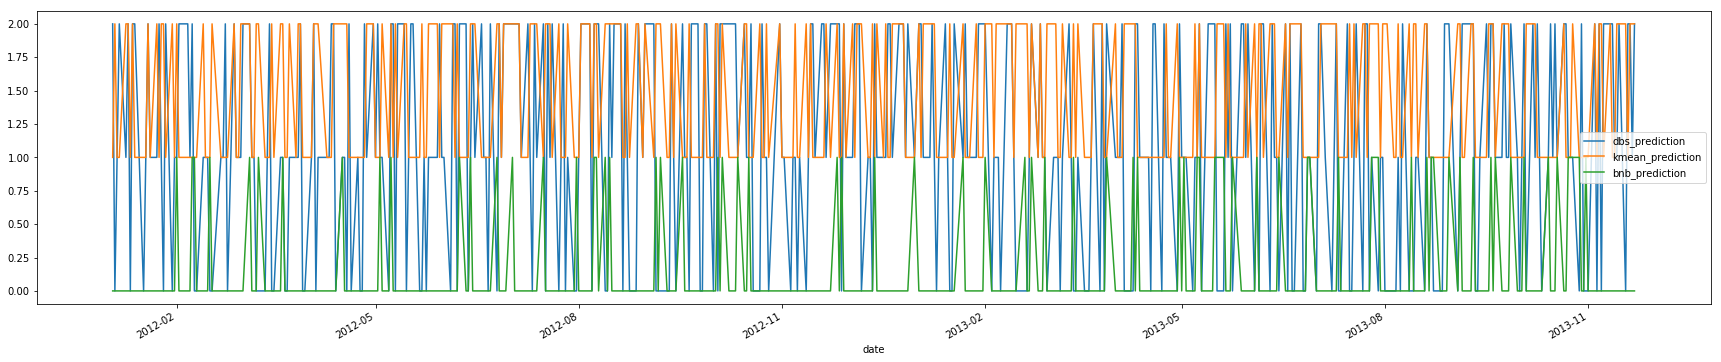

In [1268]:
rcParams['figure.figsize'] = 30, 6
manual_check.loc[manual_check.index > '2012',['dbs_prediction', 'kmean_prediction', 'bnb_prediction']].plot()
manual_check['combined_shiftback'] = manual_check['combined'].shift()
#manual_check.loc[manual_check.index > '2012',['CloseSlope', 'combined_shiftback']].plot()

In [1272]:
print(smf.ols(formula="CloseSlope ~ dbs_prediction*kmean_prediction*bnb_prediction",\
              data=manual_check).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             CloseSlope   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6964
Date:                Sat, 21 Apr 2018   Prob (F-statistic):              0.675
Time:                        19:41:20   Log-Likelihood:                -2595.0
No. Observations:                 876   AIC:                             5206.
Df Residuals:                     868   BIC:                             5244.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [734]:
manual_check.shape

(876, 6)

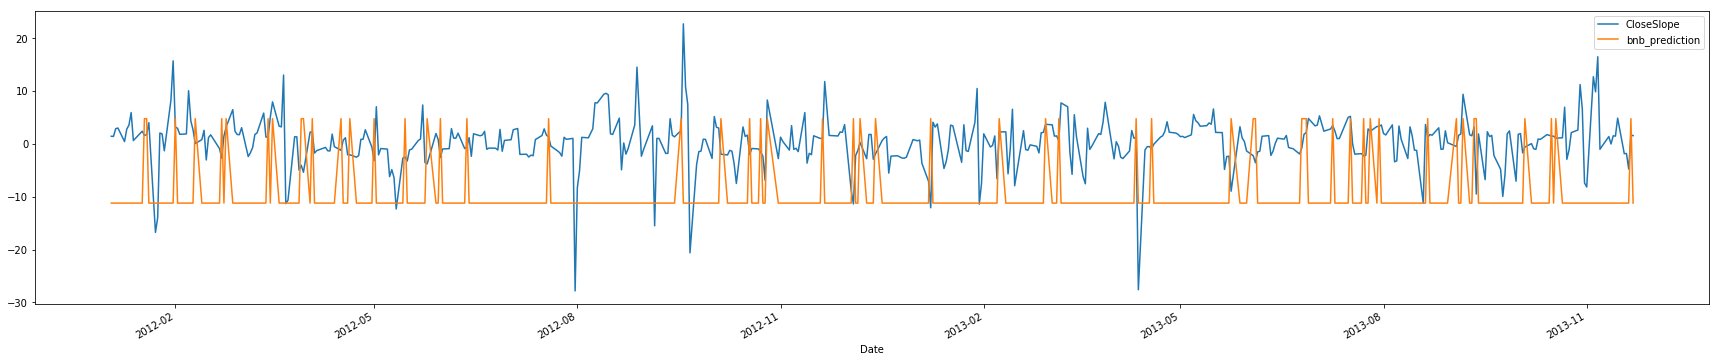

In [747]:
manual_check['bnb_prediction'] = (bnb_yhat - 0.7) * 16

manual_check.loc[manual_check.index > '2012',['CloseSlope', 'bnb_prediction']].plot()

In [728]:
manual_check.tail()

,CloseSlope,Volume,bull,bull_tomorrow,dbs_prediction,kmean_prediction,headline
2013-11-22,1.574995,26560185.0,True,True,-4,0,"-- Fed Funds Open at 0.08%, Within Target Rang..."
2013-11-22,1.574995,26560185.0,True,True,-4,0,-- Singapore Says Money-Mule Cases Increase as...
2013-11-22,1.574995,26560185.0,True,True,-4,0,-- Harvard Yoga Scientists Find Proof of Medit...
2013-11-22,1.574995,26560185.0,True,True,-4,0,-- Free Food Brings Avianca Brasil Fliers Back...
2013-11-22,1.574995,26560185.0,True,True,-4,0,"-- Taylor, Jamison Outpace Commodity Hedge Fun..."


In [1241]:
manual_check['in_bounds'] = (manual_check['dbs_prediction'] < manual_check['CloseSlope']) & (manual_check['kmean_prediction'] > manual_check['CloseSlope'])
manual_check['in_bounds'].astype('int').sum() / len(manual_check)

0.228310502283105

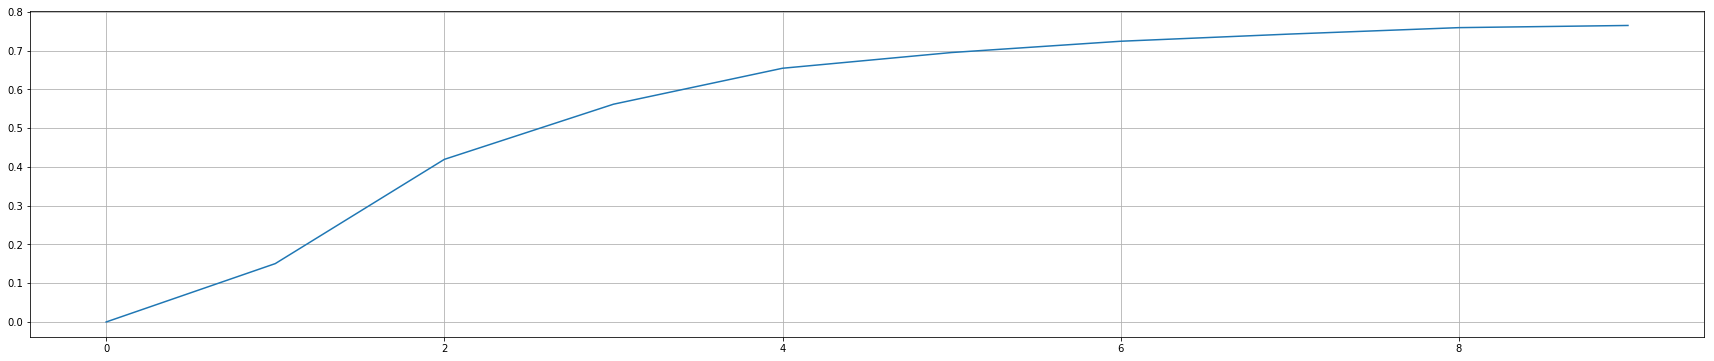

In [692]:
def multi_optimiser(manual_check, multipliers):
    
    in_bound = []
    
    for m in range(multipliers):
        manual_check = merger[['CloseSlope', 'Volume', 'bull', 'bull_tomorrow']]
        manual_check = manual_check.dropna()
        manual_check['dbs_prediction'] = dbscan.labels_ * m
        manual_check['kmean_prediction'] = kmeans.labels_ * m
        manual_check['bnb_prediction'] = (bnb_yhat - 0.5) * m
        manual_check = manual_check.merge(date_sentiment[['headline']], left_index = True, right_index = True)
        manual_check['in_bounds'] = (manual_check['dbs_prediction'] < manual_check['CloseSlope']) & (manual_check['kmean_prediction'] > manual_check['CloseSlope'])
        in_bound.append(manual_check['in_bounds'].astype('int').sum() / len(manual_check))
        
    
    plt.grid(which='both')
    plt.plot(range(multipliers), in_bound)
    return in_bound
    
in_bound = multi_optimiser(manual_check, 10)

### 4 appears to be the most optimal multiplier